Filtrado de los Datos BPM

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import ExcelWriter
from timeit import default_timer as timer
from pandas import ExcelFile
import numpy as np
import random
from numpy.random import standard_normal
from numpy import sum,isrealobj, sqrt
import math


In [30]:
def getData():
    archivo = pd.read_excel("Dataset.xlsx")
    listbpm = list(archivo["BPM"])
    listtime = list(archivo["Tiempo(s)"])
    return [listtime,listbpm]

In [31]:
def SMA (arrayData, nT):
    DataSalida = []
    FiltroTiempo = []
    aux = 0
    tiempo_i = timer()
    for i in range(len(arrayData)-nT):
        media_mov = sum(arrayData[i:i+nT])/nT
        DataSalida.append(media_mov)
    for i in range(nT):
        media_mov = sum(arrayData[-nT+aux:])/(nT-aux)
        DataSalida.append(media_mov)
        aux = aux +1
    tiempo_f = timer()
    TiempoEjecuT = tiempo_f-tiempo_i
    FiltroTiempo = [DataSalida,TiempoEjecuT]
    return FiltroTiempo

In [32]:
def avgTime(listbpm, pruebas,T_pruebas):
    duracion = []
    for i in range(pruebas):
        duracion.append(SMA(listbpm,T_pruebas)[1])
    duracionProme = sum(duracion)/pruebas
    print("En un periodo de: ", T_pruebas,"se ejecutaron: ", pruebas,". Y el tiempo promedio de ejecución fue: ", duracionProme)
    return None

In [33]:
BPM_datos = getData ();

In [34]:
Datos_Filtrados = SMA(BPM_datos[1],5);


Text(0.5, 1.0, 'Grafico de Datos BPM con y sin Filtro')

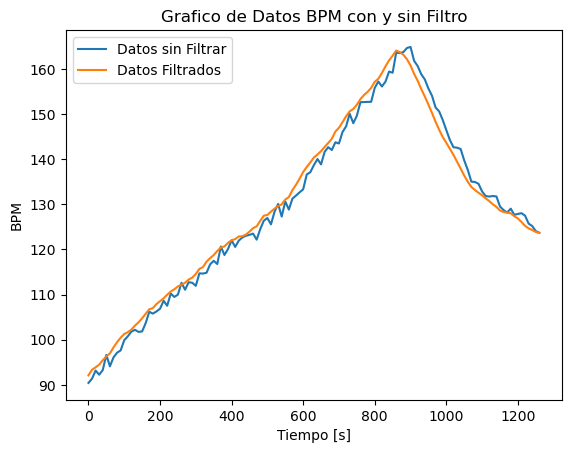

In [35]:
x = BPM_datos[0]
y = BPM_datos[1]
plt.plot(x,y)
y2 = Datos_Filtrados[0]
plt.plot(x,y2)
plt.xlabel("Tiempo [s]")
plt.ylabel("BPM")
plt.legend(['Datos sin Filtrar', 'Datos Filtrados'])
plt.title("Grafico de Datos BPM con y sin Filtro")


In [36]:
avgTime(BPM_datos[1],500,5)

En un periodo de:  5 se ejecutaron:  500 . Y el tiempo promedio de ejecución fue:  0.001619750599958934


Conversión de los datos a Binario

In [37]:
def decimal_a_binary(datosfiltrados, n_bits_msj):
    t=[]
    for i in range(0, 1270, 10):
        t.append(i)
    resolucion = 2^n_bits_msj
    ser = pd.Series(datosfiltrados, copy=False)
    c_min=round(min(datosfiltrados))
    c_max=round(max(datosfiltrados))
    x_normalizado = (ser-c_min) * (resolucion-1) / (c_max-c_min) #Se normaliza el dato, este es el que se toma
    x_normalizado[x_normalizado > resolucion - 1] = resolucion - 1
    x_normalizado[x_normalizado < 0] = 0
    x_cuant_norm = np.around(x_normalizado)
    x_cuant = round((x_cuant_norm) * (c_max-c_min) / (resolucion-1) + c_min).astype('int') #se redondea el dato 
    binario=[] 
    aux=0
    for i in x_cuant.tolist():
        binario.append(int(bin(i)[2:]))
        binario[aux]=(str(binario[aux]).rjust(n_bits_msj, '0')) # hace el reajuste de los ceros a la izquierda
        aux=aux+1
    return binario

In [38]:
def decimal_a_4bits(datosfiltrados, n_bits_msj):
    mapeo_cuatro_bits = []
    resolucion = 2^n_bits_msj
    c_min=round(min(datosfiltrados)) #valor min
    c_max=round(max(datosfiltrados)) #valor max
    for elemento in datosfiltrados:
        x_normalizado = (elemento-c_min) * (resolucion-1) / (c_max-c_min) #Se normaliza el dato, este es el que se toma
        x_cuant_norm = np.around(x_normalizado)
        x_cuant = round((x_cuant_norm) * (c_max-c_min) / (resolucion-1) + c_min) # se redondea el dato 
        
        #se discretizan a numeros del 0 al 10
        if (x_cuant<=80):
            aux = str(bin(0)[2:]).rjust(n_bits_msj, '0') # valores menores a 80 mapean a 0
        elif (80<x_cuant<=90):
            aux = str(bin(1)[2:]).rjust(n_bits_msj, '0') # valores entre 80 y 90 mapean a 1
        elif (90<x_cuant<=100):
            aux = str(bin(2)[2:]).rjust(n_bits_msj, '0') # valores entre 90 y 100 mapean a 2
        elif (100<x_cuant<=110):
            aux = str(bin(3)[2:]).rjust(n_bits_msj, '0') # valores entre 100 y 110 mapean a 3 
        elif (110<x_cuant<=120):
            aux = str(bin(4)[2:]).rjust(n_bits_msj, '0') # valores entre 110 y 120 mapean a 4
        elif (120<x_cuant<=130):
            aux = str(bin(5)[2:]).rjust(n_bits_msj, '0') # valores entre 120 y 130 mepean a 5
        elif (130<x_cuant<=140):
            aux = str(bin(6)[2:]).rjust(n_bits_msj, '0') # valores entre 130 y 140 mapean a 6
        elif (140<x_cuant<=150):
            aux = str(bin(7)[2:]).rjust(n_bits_msj, '0') # valores entre 140 y 150 mapean a 7
        elif (150<x_cuant<=160):
            aux = str(bin(8)[2:]).rjust(n_bits_msj, '0') # valores entre 150 y 160 mapean a 8
        elif (160<x_cuant<=170):
            aux = str(bin(9)[2:]).rjust(n_bits_msj, '0') # valores entre 160 y 170 mapean a 9
        elif (170<x_cuant):
            aux = str(bin(10)[2:]).rjust(n_bits_msj, '0') # valores mayores a 170 mapean a 10

        mapeo_cuatro_bits.append(aux)    
    return mapeo_cuatro_bits

In [39]:
#Codificacion Hamming
#Se tomo de https://www.geeksforgeeks.org/hamming-code-implementation-in-python/
def calcRedundantBits(m):
 #Utiliza la formula  2 ^ r >= m + r + 1
 #Para calcular la cantidad de bits redundantes
    for i in range(m):
        if(2**i >= m + i + 1):
            return i
#Funcion para calcular la posicion del bit de posicion 
def posRedundantBits(data, r):
    j = 0
    k = 1
    m = len(data)
    res = ''
 
   
    #Si la posicion es potencia de 2 devuelve 0 si no adjunta los datos
    for i in range(1, m + r+1):
        if(i == 2**j):
            res = res + '0'
            j += 1
        else:
            res = res + data[-1 * k]
            k += 1
 
  #Como es contado al revez se le da la vuelta
    return res[::-1]

In [40]:
#Calculo de los bits de pariedad
def calcParityBits(arr, r):
    n_bits = len(arr)
 
    
    for i in range(r):
        val = 0
        for j in range(1, n_bits + 1):
    #Si la posicion tiene 1 se calcula el valor del valor de bit de paridad
            # Si la posición tiene 1 en la i-ésima posición significativa
            # entonces realiza una operación OR bit a bit con el valor del array
            # para encontrar el valor del bit de paridad.
            if(j & (2**i) == (2**i)):
                val = val ^ int(arr[-1 * j])
                #Se invierten los valores
        
 
    # Concatenación
        # (0 to n_bits - 2^r) + bit de paridad + (n_bits - 2^r + 1 a n_bits)
        arr = arr[:n_bits-(2**i)] + str(val) + arr[n_bits-(2**i)+1:]
    return arr



In [41]:
#Se crea una funcion para detectar el error
def detectError(arr, nr):
    
    n_bits = len(arr)
    res = 0
     #Se calculan los bits de paridad 
    for i in range(nr):
        val = 0
        for j in range(1, n_bits + 1):
            if(j & (2**i) == (2**i)):
                val = val ^ int(arr[-1 * j])
         #Crea un valor binario con los bits de paridad
     
 
        res = res + val*(10**i)
 
    # Convierte de binario a decimal
    return int(str(res), 2)

In [42]:
DatosCodificados=[]
t_init=timer()
codificacion=7

#print(DatosBinario)

if(codificacion==7):
    archivo='datacod7.txt'
    DatosBinario=decimal_a_4bits(Datos_Filtrados[0],4)
if(codificacion==15):
    archivo='datacod15.txt'
    DatosBinario=decimal_a_binary(Datos_Filtrados[0],11)
for i in range(1,201):
    with open(archivo, 'w') as f:
        f.write(str(codificacion) + '\n')  # Agregar el "codificacion" en la primera línea
        for i in range(1, len(DatosBinario)):
            data=DatosBinario[i]
            #print(data)
            
            # Se utiliza para el calculo de cantidad de redundancia
            m = len(data)
            r = calcRedundantBits(m)

            # Calculo de posicion
            arr = posRedundantBits(data, r)

            # Se determina la paridad
            arr = calcParityBits(arr, r)
            DatosCodificados.append(arr)
            bits = ' '.join(arr)  # Para separar los bits un espacio
            f.write(bits + '\n')            
      
            
t_fin=timer()
t_hamming=t_fin-t_init
aver_time=t_hamming/200
print("El tiempo registrado es")
print (t_hamming)
print("El tiempo promedio es de")
print(aver_time)

El tiempo registrado es
0.5076876999955857
El tiempo promedio es de
0.0025384384999779285


In [43]:
data='0111'
m_bits=len(data)
r = calcRedundantBits(m_bits)
arr = posRedundantBits(data, r)
arr = calcParityBits(arr, r)
print('Se codifica el dato ' + data +' en ' + arr )

Se codifica el dato 0111 en 0110100
